In [53]:
import pandas as pd
import json

# Load the data from the JSON file
target_user_id = "6673d10b68af094502c93931"
json_file = "project_zero.running_trades.json"
exchange = "SMART"

with open(json_file) as f:
    data = json.load(f)

# Convert the JSON data to a DataFrame
df = pd.json_normalize(data)

# Define the start and end times for filtering
start_time = pd.to_datetime('13:30:00').time()
end_time = pd.to_datetime('20:00:00').time()

# Filter alerts for the given ticker and interval
alerts = df[
    #(df['symbol'] == ticker) &
    (df['user_id.$oid'] == target_user_id)
]

#if interval:
    #alerts = alerts[alerts['interval'] == interval]

# If the mode is not 'algo_summary', apply the algo filter
#if algo and mode != 'algo_summary':
    #alerts = alerts[alerts['algo'] == algo]

# Extract the nested datetime value and convert it to datetime
alerts['alerted_at'] = pd.to_datetime(alerts['alerted_at.$date'])

# Ensure that the conversion was successful
if alerts['alerted_at'].isna().any():
    print("Warning: Some 'alerted_at' values could not be converted to datetime.")

# Filter based on alerted_at between start and end times
if exchange == 'SMART':
    filtered_alerts = alerts[(alerts['alerted_at'].dt.time >= start_time) & (alerts['alerted_at'].dt.time <= end_time)]
else:
    filtered_alerts = alerts

#Sort the alerts by 'alerted_at' in descending order
filtered_alerts = filtered_alerts.sort_values(by='alerted_at', ascending=False)

# Ensure filtered_alerts is a standalone DataFrame
filtered_alerts = filtered_alerts.copy()

# Add a date column for daily grouping
filtered_alerts.loc[:, 'date'] = filtered_alerts['alerted_at'].dt.date

# Remove the last trade of each day by grouping and slicing
#filtered_alerts = filtered_alerts.groupby(['algo', 'date']).apply(lambda x: x.iloc[1:]).reset_index(drop=True)

# Define the function to calculate profit/loss
def calculate_profit_loss(row):
    if row['order_status'] in ["order_failed", "order_running"]:
        return row

    buying_total = 0
    selling_total = 0

    for event in row['events']:
        side = event['side']
        contracts = event['contracts']
        price = float(event['price'])

        if side == 'SELL':
            selling_total += contracts * price
        elif side == 'BUY':
            buying_total += contracts * price

    profit_or_loss = selling_total - buying_total
    row['profitOrLoss'] = profit_or_loss
    row['profitOrLossPercentage'] = (profit_or_loss * 100) / 500
    return row

# Apply the function to calculate profit/loss for each trade
filtered_alerts = filtered_alerts.apply(calculate_profit_loss, axis=1)
#display(filtered_alerts)
display(filtered_alerts.head(3))


/var/folders/5w/dyscq3150dx65vqv6d_qgtsm0000gn/T/ipykernel_1763/3423602714.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  alerts['alerted_at'] = pd.to_datetime(alerts['alerted_at.$date'])


,_id.$oid,alert_type,alerted_at,alerted_at.$date,algo,comment,contracts,date,entry.created_at.$date,entry.price,...,exit.type,interval,open_positions,order_status,position_propagated,profitOrLoss,profitOrLossPercentage,scaled_contracts,symbol,user_id.$oid
7080,678ffb23d9f54dfbe6beddcb,Short,2025-01-21 19:53:07.183000+00:00,2025-01-21T19:53:07.183Z,Zero-AI-1,NaN,18,2025-01-21,2025-01-21T19:53:07.183Z,32.88,...,Exit Short,1,-9,order_running,NaN,NaN,NaN,0,AI,6673d10b68af094502c93931
7079,678ff946d9f54dfbe6beddca,Long,2025-01-21 19:45:10.861000+00:00,2025-01-21T19:45:10.861Z,Zero-AI-1,NaN,30,2025-01-21,2025-01-21T19:45:10.861Z,19.99,...,Exit Long,15,30,order_running,31.0,NaN,NaN,0,MARA,6673d10b68af094502c93931
7078,678ff946d9f54dfbe6beddc9,Long,2025-01-21 19:45:10.463000+00:00,2025-01-21T19:45:10.463Z,Zero-AI-7,NaN,22,2025-01-21,2025-01-21T19:45:10.463Z,26.475,...,Exit Long,15,22,order_running,21.0,NaN,NaN,0,HUT,6673d10b68af094502c93931


Lifecycle graphs

Daily Profit/Loss by Ticker and Algo

In [54]:
# Group by 'date', 'algo', 'symbol', 'interval'
# We will calculate total profit, number of trades, and profit/loss for Long and Short trades separately.
daily_profit = filtered_alerts.groupby(['date', 'algo', 'symbol', 'interval']).agg(
    profitOrLoss=('profitOrLoss', 'sum'),       # Total profit/loss for the group
    numberOfTrades=('symbol', 'size'),         # Count of trades for the group
    profitOrLossByLong=('profitOrLoss', lambda x: x[filtered_alerts['alert_type'] == 'Long'].sum()),  # Profit for Long trades
    profitOrLossByShort=('profitOrLoss', lambda x: x[filtered_alerts['alert_type'] == 'Short'].sum()) # Profit for Short trades
).reset_index()

# Calculate profit or loss percentage for each group
daily_profit['profitOrLossPercentage'] = (daily_profit['profitOrLoss'] * 100 / 500)

# Calculate profit/loss percentages for Long and Short separately
daily_profit['profitOrLossPercentage_Long'] = (daily_profit['profitOrLossByLong'] * 100 / 500)
daily_profit['profitOrLossPercentage_Short'] = (daily_profit['profitOrLossByShort'] * 100 / 500)

# Display the grouped daily profits
pd.set_option('display.max_rows', None)  # Optional: Display all rows if needed
display(daily_profit.head(3))

# Calculate and print total profit and trades for the period
total_daily_profit = daily_profit['profitOrLoss'].sum()
total_trades = daily_profit['numberOfTrades'].sum()
total_profit_long = daily_profit['profitOrLossByLong'].sum()
total_profit_short = daily_profit['profitOrLossByShort'].sum()

print(f"Total Profit: {total_daily_profit}")
print(f"Total Number of Trades: {total_trades}")
print(f"Total Profit from Long Trades: {total_profit_long}")
print(f"Total Profit from Short Trades: {total_profit_short}")


,date,algo,symbol,interval,profitOrLoss,numberOfTrades,profitOrLossByLong,profitOrLossByShort,profitOrLossPercentage,profitOrLossPercentage_Long,profitOrLossPercentage_Short
0,2024-11-07,Zero-AI-1,AFRM,3,-12.3285,3,-4.1925,-8.136,-2.4657,-0.8385,-1.6272
1,2024-11-07,Zero-AI-1,AFRM,5,-14.2200,2,-7.0200,-7.200,-2.8440,-1.4040,-1.4400
2,2024-11-07,Zero-AI-1,AI,1,10.8925,4,3.8725,7.020,2.1785,0.7745,1.4040


Total Profit: 1615.5616522499913
Total Number of Trades: 5733
Total Profit from Long Trades: -815.9989642500007
Total Profit from Short Trades: 2431.5606164999926


Display on Graph

/var/folders/5w/dyscq3150dx65vqv6d_qgtsm0000gn/T/ipykernel_1763/3638186379.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_symbol_interval_algo_profit.loc[:, 'cumulative_profitOrLossPercentage'] = filtered_symbol_interval_algo_profit.groupby('algo')['profitOrLossPercentage'].cumsum()
/var/folders/5w/dyscq3150dx65vqv6d_qgtsm0000gn/T/ipykernel_1763/3638186379.py:20: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_symbol_interval_algo_profit['algo_cumulative'] = filtered_symbol_interval_al

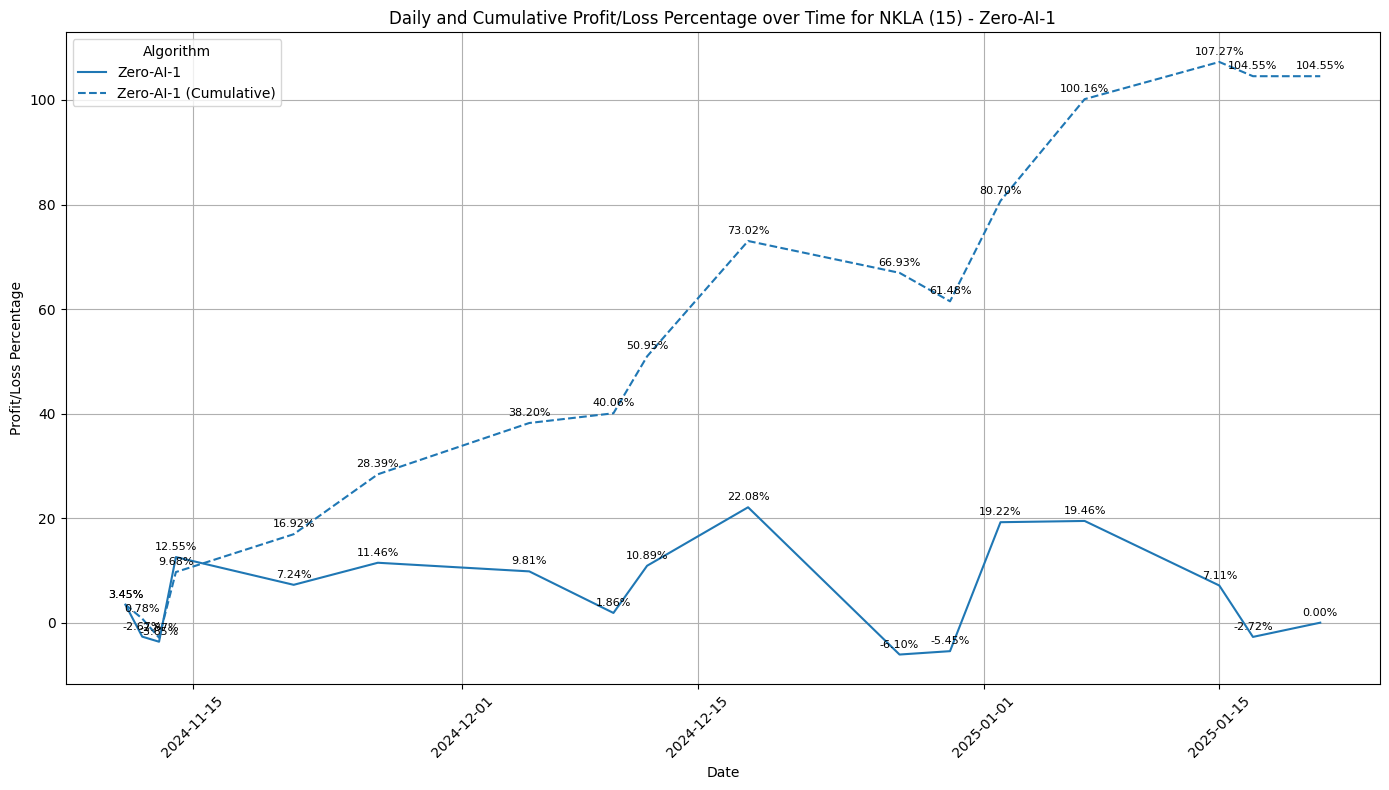

Total Cumulative Profit/Loss Percentage for NKLA (15, Zero-AI-1): 104.54750000000006


In [40]:
import matplotlib.pyplot as plt
import seaborn as sns

# Example: Filter by a specific symbol, interval, and algorithm
symbol_to_display = 'NKLA'  # Change to your desired symbol
interval_to_display = '15'  # Change to your desired interval, e.g., '1min', '5min', etc.
algo_to_display = 'Zero-AI-1'  # Change to your desired algorithm, e.g., 'algo1', 'algo2', etc.

# Filter the daily_profit DataFrame to show only the selected symbol, interval, and algorithm
filtered_symbol_interval_algo_profit = daily_profit[
    (daily_profit['symbol'] == symbol_to_display) & 
    (daily_profit['interval'] == interval_to_display) & 
    (daily_profit['algo'] == algo_to_display)
]

# Calculate cumulative profitOrLossPercentage using .loc to avoid the SettingWithCopyWarning
filtered_symbol_interval_algo_profit.loc[:, 'cumulative_profitOrLossPercentage'] = filtered_symbol_interval_algo_profit.groupby('algo')['profitOrLossPercentage'].cumsum()

# Modify data for separate legends for daily and cumulative
filtered_symbol_interval_algo_profit['algo_cumulative'] = filtered_symbol_interval_algo_profit['algo'] + " (Cumulative)"

plt.figure(figsize=(14, 8))

# Plot daily profitOrLossPercentage
sns.lineplot(data=filtered_symbol_interval_algo_profit, x='date', y='profitOrLossPercentage', hue='algo', markers=True)

# Plot cumulative profitOrLossPercentage with updated legend
sns.lineplot(data=filtered_symbol_interval_algo_profit, x='date', y='cumulative_profitOrLossPercentage', hue='algo_cumulative', linestyle='--', markers=True)

# Annotate daily profitOrLossPercentage with values
for i in range(len(filtered_symbol_interval_algo_profit)):
    plt.annotate(f"{filtered_symbol_interval_algo_profit['profitOrLossPercentage'].iloc[i]:.2f}%",
                 (filtered_symbol_interval_algo_profit['date'].iloc[i], filtered_symbol_interval_algo_profit['profitOrLossPercentage'].iloc[i]),
                 textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8)

# Annotate cumulative profitOrLossPercentage with values
for i in range(len(filtered_symbol_interval_algo_profit)):
    plt.annotate(f"{filtered_symbol_interval_algo_profit['cumulative_profitOrLossPercentage'].iloc[i]:.2f}%",
                 (filtered_symbol_interval_algo_profit['date'].iloc[i], filtered_symbol_interval_algo_profit['cumulative_profitOrLossPercentage'].iloc[i]),
                 textcoords="offset points", xytext=(0, 5), ha='center', fontsize=8)

# Customize the plot
plt.title(f'Daily and Cumulative Profit/Loss Percentage over Time for {symbol_to_display} ({interval_to_display}) - {algo_to_display}')
plt.xlabel('Date')
plt.ylabel('Profit/Loss Percentage')
plt.legend(title='Algorithm')  # Legend will now distinguish cumulative
plt.xticks(rotation=45)  # Rotate date labels for better visibility
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()

# Calculate and print the total cumulative profit/loss for the selected symbol, interval, and algorithm
total_cumulative_profit_loss_percentage = filtered_symbol_interval_algo_profit['cumulative_profitOrLossPercentage'].iloc[-1]
print(f"Total Cumulative Profit/Loss Percentage for {symbol_to_display} ({interval_to_display}, {algo_to_display}): {total_cumulative_profit_loss_percentage}")


Setup With highest profit percentage

In [55]:

# Sort by 'profitOrLossPercentage' in descending order
sorted_daily_profit = daily_profit.sort_values(by='profitOrLossPercentage', ascending=False)

# Group by 'algo', 'symbol', and 'interval' and then calculate the trend within each group
sorted_daily_profit['trend'] = sorted_daily_profit.groupby(['algo', 'symbol', 'interval'])['profitOrLossPercentage'].diff().apply(
    lambda x: 'Up' if x > 0 else ('Down' if x < 0 else 'No Change')
)

# Display the sorted DataFrame with the trend column
pd.set_option('display.max_rows', None)  # Optional: Display all rows if needed
#display(sorted_daily_profit)

Calculate Profit per Ticker, Interval, and Algo

In [42]:
# Group by 'algo', 'symbol', and 'interval' to calculate overall and segmented profits
print(sorted_daily_profit.columns)
profit_by_ticker_interval_algo = sorted_daily_profit.groupby(['algo', 'symbol', 'interval']).agg(
    profitOrLossPercentage=('profitOrLossPercentage', 'sum'),  # Total profit/loss percentage for the group
    totalNumberOfTrades=('numberOfTrades', 'sum'),            # Total number of trades
    profitOrLossPercentageLong=('profitOrLossPercentage_Long', 'sum'),  # Total profit percentage for Long trades
    profitOrLossPercentageShort=('profitOrLossPercentage_Short', 'sum'), # Total profit percentage for Short trades
).reset_index()

# Group by 'algo', 'symbol', and 'interval' to calculate the trend within each group
profit_by_ticker_interval_algo['trend'] = sorted_daily_profit.groupby(['algo', 'symbol', 'interval'])['profitOrLossPercentage'].diff().apply(
    lambda x: 'Up' if x > 0 else ('Down' if x < 0 else 'No Change')
)

# Sort the result by total profit in descending order
profit_by_ticker_interval_algo = profit_by_ticker_interval_algo.sort_values(by='profitOrLossPercentage', ascending=False)

# Display the result with trend
pd.set_option('display.max_rows', None)  # Optional: Display all rows if needed
display(profit_by_ticker_interval_algo)


Index(['date', 'algo', 'symbol', 'interval', 'profitOrLoss', 'numberOfTrades',
       'profitOrLossByLong', 'profitOrLossByShort', 'profitOrLossPercentage',
       'profitOrLossPercentage_Long', 'profitOrLossPercentage_Short', 'trend'],
      dtype='object')


,algo,symbol,interval,profitOrLossPercentage,totalNumberOfTrades,profitOrLossPercentageLong,profitOrLossPercentageShort,trend
44,Zero-AI-1,NKLA,15,104.547500,19,38.632500,65.915000,Down
28,Zero-AI-1,HUT,5,71.831520,76,64.291680,7.539840,Down
27,Zero-AI-1,HUT,3,57.177610,113,44.975700,12.201910,Down
57,Zero-AI-1,QSI,3,52.786000,21,0.376000,52.410000,Down
59,Zero-AI-1,QUBT,15,37.930000,3,0.000000,37.930000,Down
74,Zero-AI-1,TSLA,3,36.200890,80,30.061930,6.138960,Down
91,Zero-AI-7,MARA,15,35.818780,46,25.678980,10.139800,No Change
92,Zero-AI-7,NKLA,15,35.364451,30,-34.660333,70.024784,Down
82,Zero-AI-7,AFRM,15,34.837660,34,35.743180,-0.905520,Down
75,Zero-AI-1,UPST,15,34.362220,22,14.808080,19.554140,Down


Analyze Most SL Trigger Times

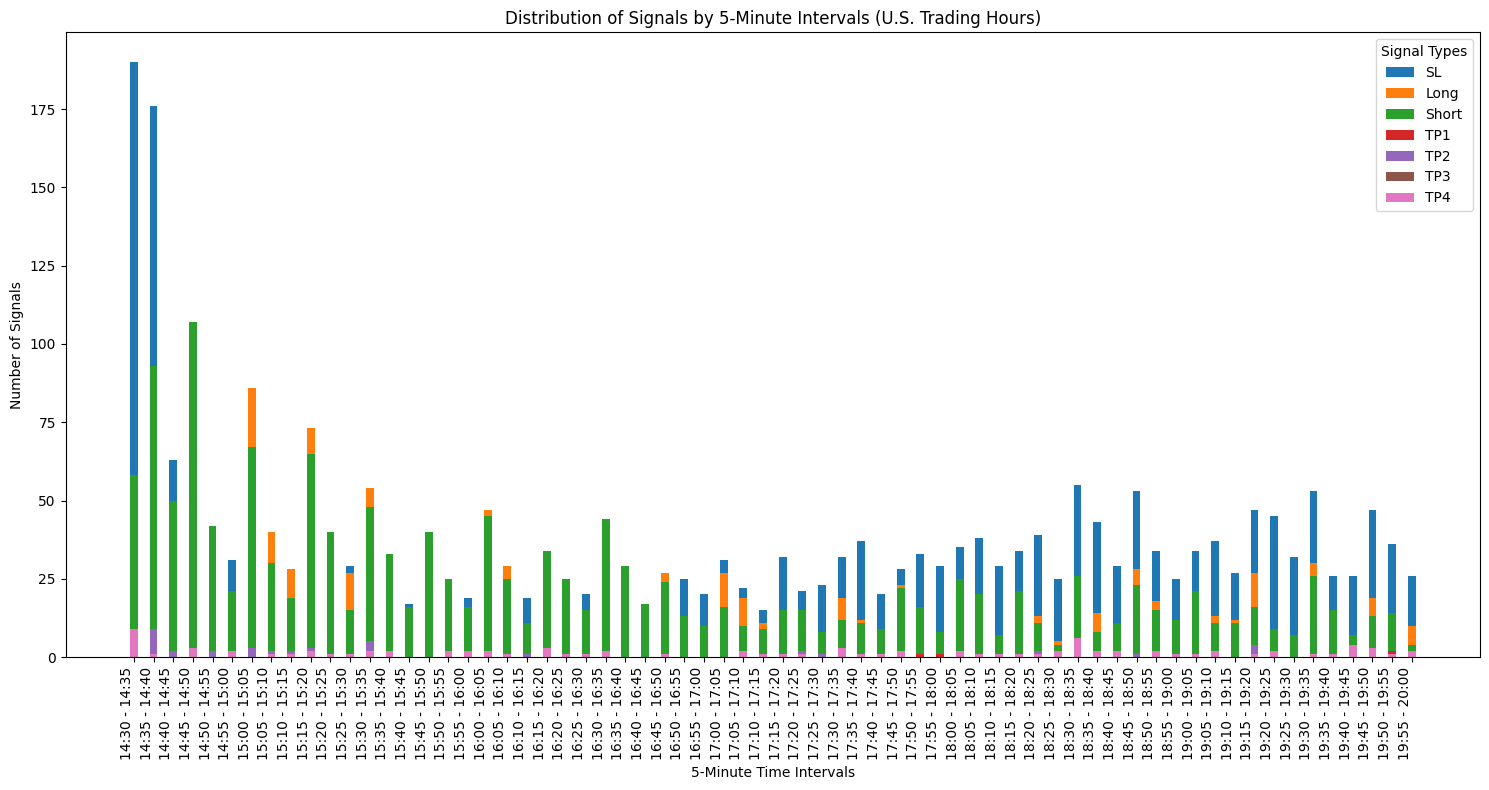

Signal Distribution by 5-Minute Intervals:
     time_interval exit.signal  signal_count
0    14:30 - 14:35        Long            37
1    14:30 - 14:35          SL           190
2    14:30 - 14:35       Short            58
3    14:30 - 14:35         TP1             3
4    14:30 - 14:35         TP2             3
5    14:30 - 14:35         TP3             1
6    14:30 - 14:35         TP4             9
12   14:35 - 14:40         TP4             1
11   14:35 - 14:40         TP2             9
10   14:35 - 14:40         TP1             1
9    14:35 - 14:40       Short            93
8    14:35 - 14:40          SL           176
7    14:35 - 14:40        Long            73
13   14:40 - 14:45        Long            39
14   14:40 - 14:45          SL            63
15   14:40 - 14:45       Short            50
16   14:40 - 14:45         TP2             2
21   14:45 - 14:50         TP4             3
20   14:45 - 14:50         TP2             3
17   14:45 - 14:50        Long            92
18   14:45 -

In [64]:
import pandas as pd
from datetime import time, timedelta
import matplotlib.pyplot as plt

# Step 1: Define U.S. trading hours in UTC
market_open = time(14, 30)  # 14:30 UTC
market_close = time(22, 0)  # 22:00 UTC (adjusted as per your request)

# Step 2: Generate 5-minute intervals
def generate_intervals(start_time, end_time, interval_minutes):
    intervals = []
    current_time = pd.Timestamp.combine(pd.Timestamp.today(), start_time)
    end_time = pd.Timestamp.combine(pd.Timestamp.today(), end_time)
    interval_delta = timedelta(minutes=interval_minutes)
    
    while current_time < end_time:
        interval_start = current_time.time()
        interval_end = (current_time + interval_delta).time()
        intervals.append(f"{interval_start.strftime('%H:%M')} - {interval_end.strftime('%H:%M')}")
        current_time += interval_delta
    
    return intervals

# Generate 5-minute intervals for U.S. trading hours
time_intervals = generate_intervals(market_open, market_close, 5)

# Step 3: Assign each event to a 5-minute interval
def assign_time_interval(row, intervals):
    for interval in intervals:
        start, end = interval.split(" - ")
        if time.fromisoformat(start) <= row['alerted_at'].time() < time.fromisoformat(end):
            return interval
    return None

# Assuming filtered_alerts['alerted_at'] is already a datetime column
filtered_alerts['time_interval'] = filtered_alerts.apply(
    lambda row: assign_time_interval(row, time_intervals), axis=1
)

# Step 4: Filter for all signal types (SL, Long, Short, TP1, TP2, TP3, TP4)
signals_of_interest = ['SL', 'Long', 'Short', 'TP1', 'TP2', 'TP3', 'TP4']
events_of_interest = filtered_alerts[filtered_alerts['exit.signal'].isin(signals_of_interest)]

# Step 5: Analyze the distribution of signals in the 5-minute intervals
signal_distribution = events_of_interest.groupby(['time_interval', 'exit.signal']).size().reset_index(name='signal_count')

# Step 6: Sort results by time interval
signal_distribution = signal_distribution.sort_values('time_interval')

# Step 7: Calculate total counts for each signal type
signal_totals = signal_distribution.groupby('exit.signal')['signal_count'].sum().reset_index(name='total_count')

# Step 8: Plot the distribution for all signals
plt.figure(figsize=(15, 8))
for signal in signals_of_interest:
    signal_data = signal_distribution[signal_distribution['exit.signal'] == signal]
    plt.bar(signal_data['time_interval'], signal_data['signal_count'], label=signal, width=0.4, align='center')

plt.xticks(rotation=90, ha='right')
plt.xlabel("5-Minute Time Intervals")
plt.ylabel("Number of Signals")
plt.title("Distribution of Signals by 5-Minute Intervals (U.S. Trading Hours)")
plt.legend(title="Signal Types")
plt.tight_layout()
plt.show()

# Print the signal distribution table
print("Signal Distribution by 5-Minute Intervals:")
print(signal_distribution)

# Print the total count for each signal type
print("\nTotal Signal Counts:")
print(signal_totals)


Most TP1 hit time

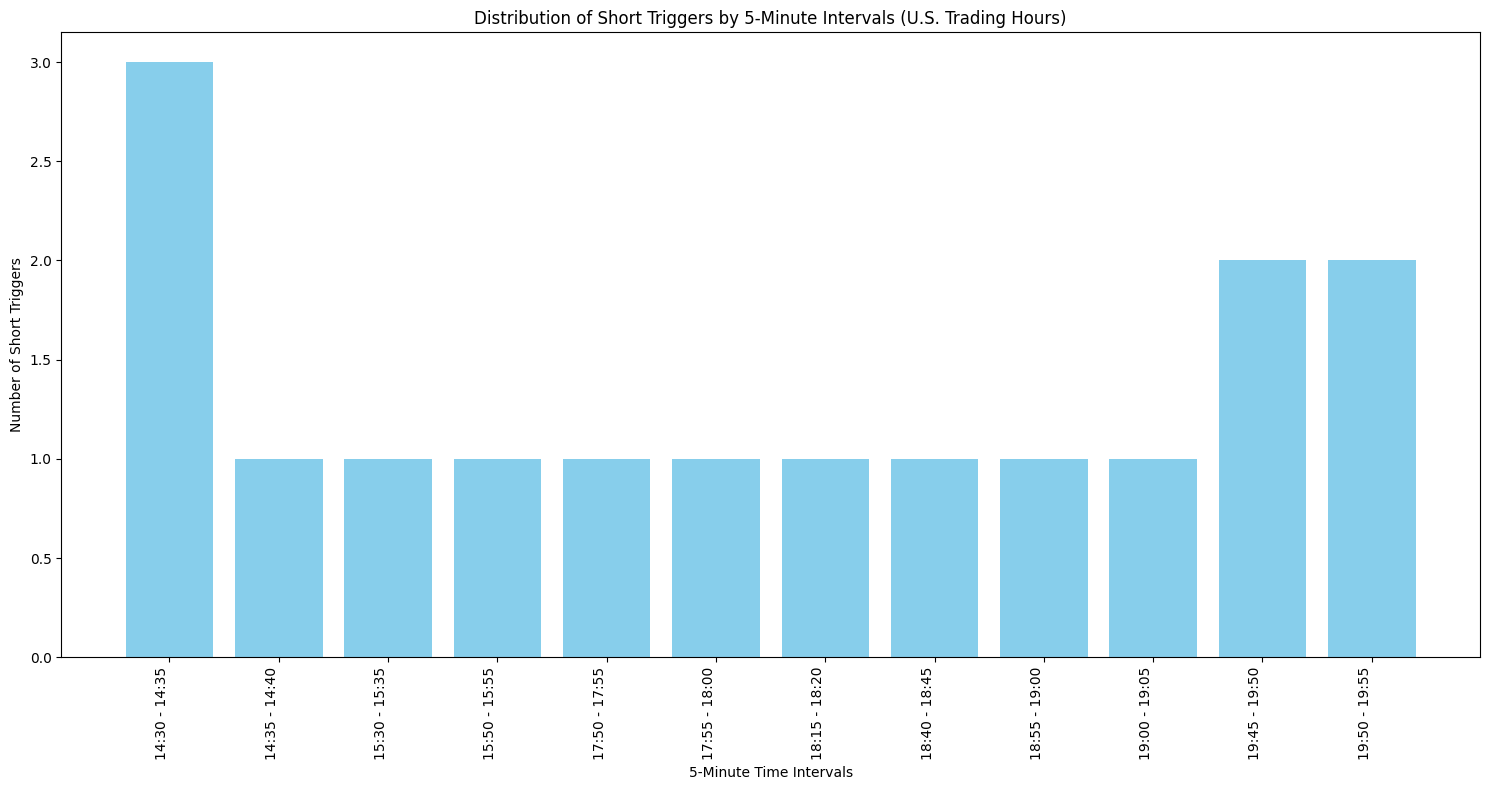

Short Trigger Distribution by 5-Minute Intervals:
    time_interval  sl_count
0   14:30 - 14:35         3
1   14:35 - 14:40         1
2   15:30 - 15:35         1
3   15:50 - 15:55         1
4   17:50 - 17:55         1
5   17:55 - 18:00         1
6   18:15 - 18:20         1
7   18:40 - 18:45         1
8   18:55 - 19:00         1
9   19:00 - 19:05         1
10  19:45 - 19:50         2
11  19:50 - 19:55         2


In [61]:
import pandas as pd
from datetime import time, timedelta
import matplotlib.pyplot as plt

# Step 1: Define U.S. trading hours in UTC
market_open = time(14, 30)  # 14:30 UTC
market_close = time(22, 0)  # 21:00 UTC

# Step 2: Generate 5-minute intervals
def generate_intervals(start_time, end_time, interval_minutes):
    intervals = []
    current_time = pd.Timestamp.combine(pd.Timestamp.today(), start_time)
    end_time = pd.Timestamp.combine(pd.Timestamp.today(), end_time)
    interval_delta = timedelta(minutes=interval_minutes)
    
    while current_time < end_time:
        interval_start = current_time.time()
        interval_end = (current_time + interval_delta).time()
        intervals.append(f"{interval_start.strftime('%H:%M')} - {interval_end.strftime('%H:%M')}")
        current_time += interval_delta
    
    return intervals

# Generate 5-minute intervals for U.S. trading hours
time_intervals = generate_intervals(market_open, market_close, 5)

# Step 3: Assign each TP1 event to a 5-minute interval
def assign_time_interval(row, intervals):
    for interval in intervals:
        start, end = interval.split(" - ")
        if time.fromisoformat(start) <= row['alerted_at'].time() < time.fromisoformat(end):
            return interval
    return None

# Assuming filtered_alerts['alerted_at'] is already a datetime column
filtered_alerts['time_interval'] = filtered_alerts.apply(
    lambda row: assign_time_interval(row, time_intervals), axis=1
)

# Step 4: Filter for SL signals
sl_events = filtered_alerts[filtered_alerts['exit.signal'] == 'TP1']

# Step 5: Analyze SL trigger distribution
sl_distribution = sl_events.groupby('time_interval').size().reset_index(name='sl_count')

# Step 6: Sort results by time interval
sl_distribution = sl_distribution.sort_values('time_interval')

# Step 7: Plot the distribution
plt.figure(figsize=(15, 8))
plt.bar(sl_distribution['time_interval'], sl_distribution['sl_count'], color='skyblue')
plt.xticks(rotation=90, ha='right')
plt.xlabel("5-Minute Time Intervals")
plt.ylabel("Number of Short Triggers")
plt.title("Distribution of Short Triggers by 5-Minute Intervals (U.S. Trading Hours)")
plt.tight_layout()
plt.show()

# Print the SL trigger distribution table
print("Short Trigger Distribution by 5-Minute Intervals:")
print(sl_distribution)
